![](http://)![](http://)
## First Take  :  Home Credit Default Risk Competition
#CREDIT: Will Koehrsen - A Gentle Introduction

* The objective of this competition is to use historical loan application data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classification task:


## Data

The data is provided by [Home Credit](http://www.homecredit.net/about-us.aspx)
In this notebook, we will stick to using only the main application training and testing data. 

* application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature `SK_ID_CURR`. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid. 

#### Metric: ROC AUC

Submission is judge by ROC  AUC.The [Reciever Operating Characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) graphs the true positive rate versus the false positive rate:

![image](http://www.statisticshowto.com/wp-content/uploads/2016/08/ROC-curve.png)

let's get into exploring the data. In this notebook,we will stick to the main data sources and simple models which we can build upon in future work. 


In [13]:
#google api imports check if we have access to storage bucket from notebook 
# #bucket /pditi-data/datasets

import google.datalab.storage as storage
from google.datalab import Context
import random, string
sample_bucket_name = 'pditi-data' 
sample_bucket_path = 'gs://' + sample_bucket_name
sample_bucket_object = sample_bucket_path + '/datasets'
print('Bucket: ' + sample_bucket_path)
print('Object: ' + sample_bucket_object)

Bucket: gs://pditi-data
Object: gs://pditi-data/datasets


Bucket: gs://neukaggle-datalab-samples-
Object: gs://neukaggle-datalab-samples-/Hello.txt


## Imports

We are using a typical data science stack: `numpy`, `pandas`, `sklearn`, `matplotlib`. 

In [14]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
import google.datalab.storage as storage

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns


## Read in Data 

First, we can list all the available data files. There are a total of 9 files: 1 main file for training (with target) 1 main file for testing (without the target), 1 example submission file, and 6 other files containing additional information about each loan. 

In [10]:
# Training data
#copt once to notebook
#!gsutil cp 'gs://pditi-data/datasets/application_train.csv'  'application_train'
#!gsutil ls gs://pditi-data/datasets
app_train = pd.read_csv('application_train')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the `TARGET` (the label we want to predict).

In [12]:
# Testing data features
#copy once to notebook . 
#!gsutil cp 'gs://pditi-data/datasets/application_test.csv'  'application_test'
app_test = pd.read_csv('application_test')
print('Testing data shape: ', app_test.shape)
app_test.head()

Copying gs://pditi-data/datasets/application_test.csv...
/ [1 files][ 25.3 MiB/ 25.3 MiB]                                                
Operation completed over 1 objects/25.3 MiB.                                     
Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


The test set is considerably smaller and lacks a `TARGET` column. 

# Exploratory Data Analysis

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data. The goal of EDA is to learn what our data can tell us. It generally starts out with a high level overview, then narrows in to specific areas as we find intriguing areas of the data. The findings may be interesting in their own right, or they can be used to inform our modeling choices, such as by helping us decide which features to use.

## Examine the Distribution of the Target Column

The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

In [15]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

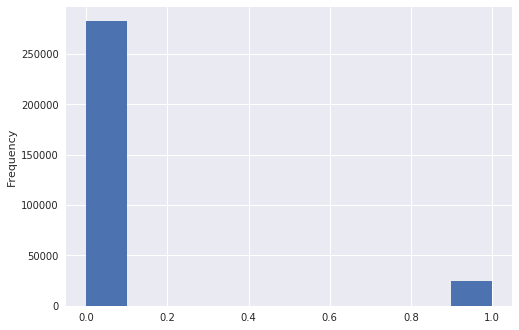

In [16]:
app_train['TARGET'].astype(int).plot.hist();

From this information, we see this is an [_imbalanced class problem_](http://www.chioka.in/class-imbalance-problem/). There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can [weight the classes](http://xgboost.readthedocs.io/en/latest/parameter.html) by their representation in the data to reflect this imbalance. 

## Examine Missing Values

Next we can look at the number and percentage of missing values in each column. 

In [17]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [18]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). In later work, we will use models such as XGBoost that can [handle missing values with no need for imputation](https://stats.stackexchange.com/questions/235489/xgboost-can-handle-missing-data-in-the-forecasting-phase). Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

## Column Types

Let's look at the number of columns of each data type. `int64` and `float64` are numeric variables ([which can be either discrete or continuous](https://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data)). `object` columns contain strings and are  [categorical features.](http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/what-are-categorical-discrete-and-continuous-variables/) . 

In [19]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Let's now look at the number of unique entries in each of the `object` (categorical) columns.

In [20]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables! 

## Encoding Categorical Variables

Before we go any further, we need to deal with categorical variables.Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process:

* Label encoding: assign each unique category in a categorical variable with an integer. No new columns are created.

* One-hot encoding: create a new column for each unique category in a categorical variable. 

In this notebook, we will use Label Encoding for any categorical variables with only 2 categories and One-Hot Encoding for any categorical variables with more than 2 categories.We will also not use any dimensionality reduction in this notebook but will explore in future iterations.

### Label Encoding and One-Hot Encoding

Let's implement the policy described above. For label encoding, we use the Scikit-Learn `LabelEncoder` and for one-hot encoding, the pandas `get_dummies(df)` function.

In [21]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [22]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


### Aligning Training and Testing Data

There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data.

To remove the columns in the training data that are not in the testing data, we need to `align` the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set `axis = 1` to align the dataframes based on the columns and not on the rows!

In [23]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


The training and testing datasets now have the same features which is required for machine learning. The number of features has grown significantly due to one-hot encoding. At some point we probably will want to try [dimensionality reduction (removing features that are not relevant)](https://en.wikipedia.org/wiki/Dimensionality_reduction) to reduce the size of the datasets.

## Back to Exploratory Data Analysis

### Anomalies

One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the `describe` method. The numbers in the `DAYS_BIRTH` column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:



In [24]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment? 

In [25]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

That doesn't look right! The maximum value (besides being positive) is about 1000 years! 

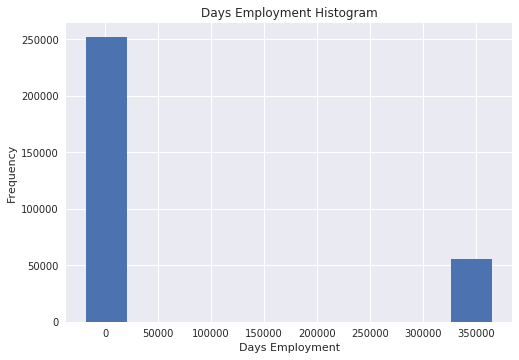

In [26]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Just out of curiousity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [27]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Well that is extremely interesting! It turns out that the anomalies have a lower rate of default. 

Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values.
* As a solution, we will fill in the anomalous values with not a number (`np.nan`) and then create a new boolean column indicating whether or not the value was anomalous.



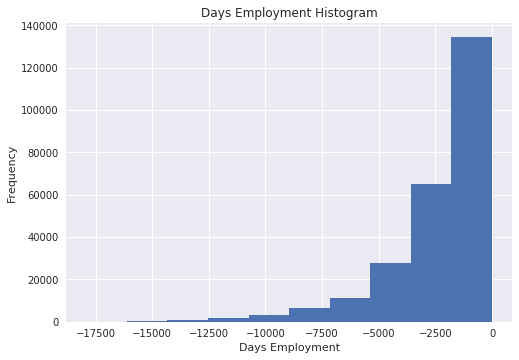

In [28]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

The distribution looks to be much more in line with what we would expect, and we also have created a new column to tell the model that these values were originally anomalous (becuase we will have to fill in the nans with some value, probably the median of the column). The other columns with `DAYS` in the dataframe look to be about what we expect with no obvious outliers. 

As an extremely important note, anything we do to the training data we also have to do to the testing data. Let's make sure to create the new column and fill in the existing column with `np.nan` in the testing data.

In [29]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


### Correlations

Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the `.corr` dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some [general interpretations of the absolute value of the correlation coefficent](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf) are:


* .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
* .80-1.0 “very strong”


In [30]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Let's take a look at some of more significant correlations: the `DAYS_BIRTH` is the most positive correlation. Looking at the documentation, `DAYS_BIRTH` is the age in days of the client at the time of the loan in negative days.The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.

### Effect of Age on Repayment

In [31]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982712

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often. 

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.

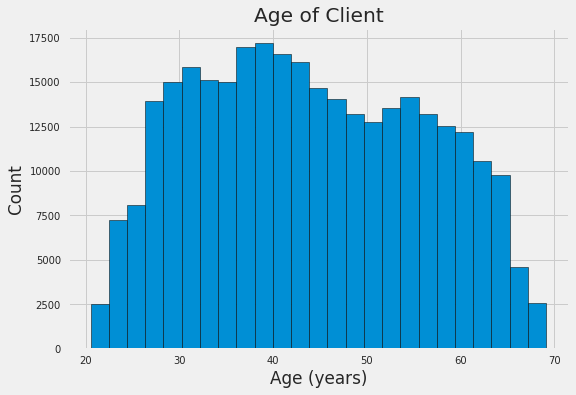

In [32]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a [kernel density estimation plot](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) colored by the value of the target. A [kernel density estimate plot shows the distribution of a single variable](https://chemicalstatistician.wordpress.com/2013/06/09/exploratory-data-analysis-kernel-density-estimation-in-r-on-ozone-pollution-data-in-new-york-and-ozonopolis/) and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn `kdeplot` for this graph.

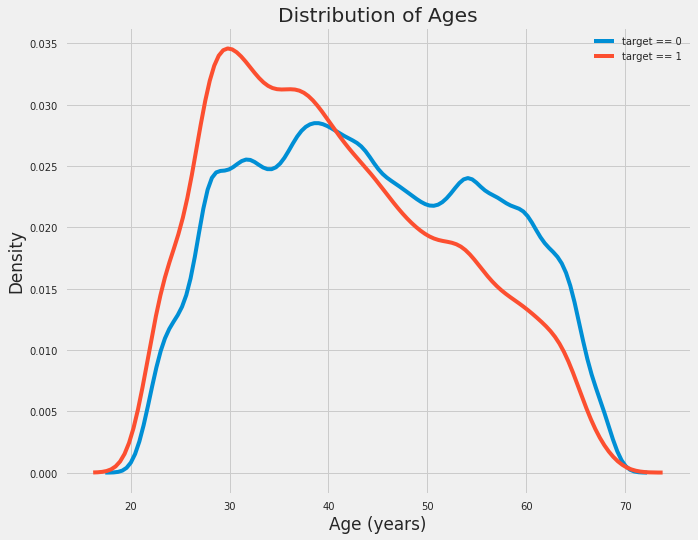

In [33]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket. 

To make this graph, first we `cut` the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [34]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [35]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


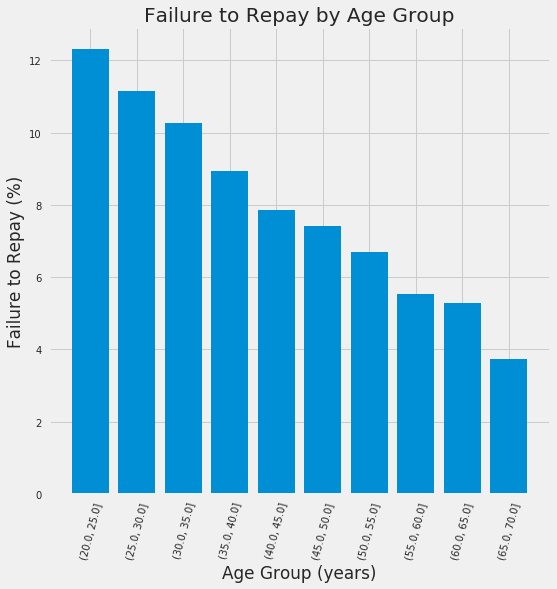

In [36]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

### Exterior Sources

The 3 variables with the strongest negative correlations with the target are `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`.
According to the documentation, these features represent a "normalized score from external data source". it may be a cumulative sort of credit rating made using numerous sources of data. 
Let's take a look at these variables.
* First, we can show the correlations of the `EXT_SOURCE` features with the target and with each other.

In [37]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


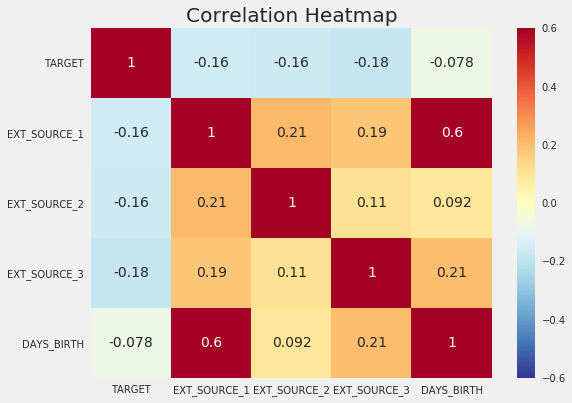

In [38]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

All three `EXT_SOURCE` featureshave negative correlations with the target, indicating that as the value of the `EXT_SOURCE` increases, the client is more likely to repay the loan. We can also see that `DAYS_BIRTH` is positively correlated with `EXT_SOURCE_1` indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

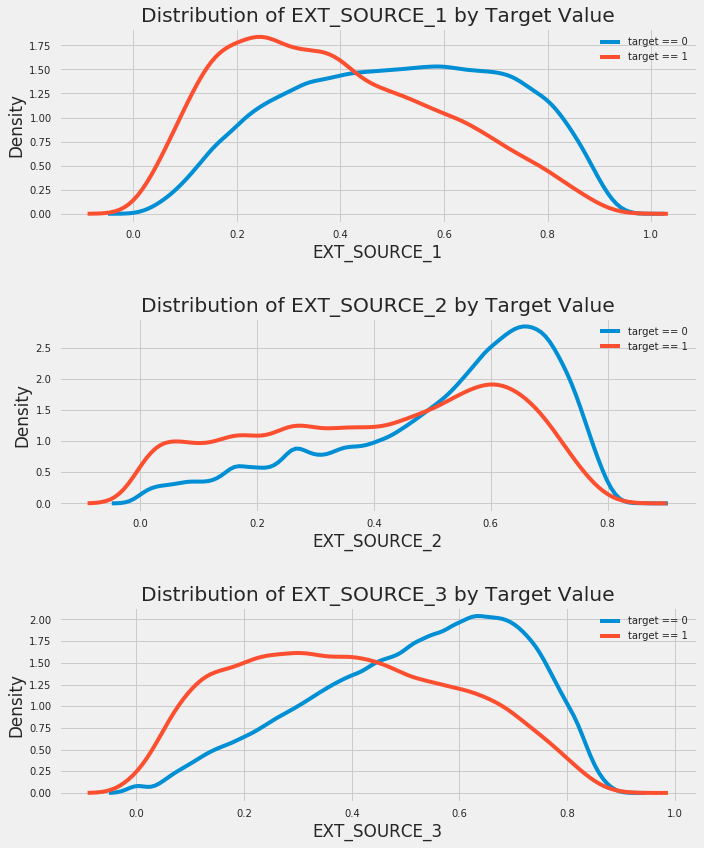

In [39]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

`EXT_SOURCE_3` displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all [considered very weak](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf), but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

## Pairs Plot

As a final exploratory plot, we can make a pairs plot of the `EXT_SOURCE` variables and the `DAYS_BIRTH` variable. The [Pairs Plot](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166) is a great exploration tool because it lets us see relationships between multiple pairs of variables as well as distributions of single variables. Here we are using the seaborn visualization library and the PairGrid function to create a Pairs Plot with scatterplots on the upper triangle, histograms on the diagonal, and 2D kernel density plots and correlation coefficients on the lower triangle.

If you don't understand this code, that's all right! Plotting in Python can be overly complex, and for anything beyond the simplest graphs, I usually find an existing implementation and adapt the code (don't repeat yourself)! 

In [ ]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

In this plot, the red indicates loans that were not repaid and the blue are loans that are paid. We can see the different relationships within the data. There does appear to be a moderate positive linear relationship between the `EXT_SOURCE_1` and the `DAYS_BIRTH` (or equivalently `YEARS_BIRTH`), indicating that this feature may take into account the age of the client. 

# Feature Engineering

Feature engineering refers to a geneal process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only the most important features or other methods of dimensionality reduction. There are many techniques we can use to both create features and select features.

This notebook we will try only two simple feature construction methods: 

* Polynomial features
* Domain knowledge features


## Polynomial Features

One simple feature construction method is called [polynomial features](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). In this method, we make features that are powers of existing features as well as interaction terms between existing features. For example, we can create variables `EXT_SOURCE_1^2` and `EXT_SOURCE_2^2` and also variables such as `EXT_SOURCE_1` x `EXT_SOURCE_2`, `EXT_SOURCE_1` x `EXT_SOURCE_2^2`, `EXT_SOURCE_1^2` x   `EXT_SOURCE_2^2`, and so on.

These features that are a combination of multiple individual variables are called [interaction terms](https://en.wikipedia.org/wiki/Interaction_(statistics) because they  capture the interactions between variables. In other words, while two variables by themselves  may not have a strong influence on the target, combining them together into a single interaction variable might show a relationship with the target. [Interaction terms are commonly used in statistical models](https://www.theanalysisfactor.com/interpreting-interactions-in-regression/) to capture the effects of multiple variables, but I do not see them used as often in machine learning. Nonetheless, we can try out a few to see if they might help our model to predict whether or not a client will repay a loan. 

In the following code, we create polynomial features using the `EXT_SOURCE` variables and the `DAYS_BIRTH` variable. [Scikit-Learn has a useful class called `PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) that creates the polynomials and the interaction terms up to a specified degree. We can use a degree of 3 to see the results 

In [ ]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [ ]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

This creates a considerable number of new features. To get the names we have to use the polynomial features `get_feature_names` method.

In [ ]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

There are 35 features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.

In [ ]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn. 

We will add these features to a copy of the training and testing data and then evaluate models with and without the features. Many times in machine learning, the only way to know if an approach will work is to try it out! 

In [ ]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

## Domain Knowledge Features

Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by [this script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) by Aguiar:

* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
* `CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

Again, thanks to Aguiar and [his great script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) for exploring these features.



In [ ]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [ ]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

#### Visualize New Variables

We should explore these __domain knowledge__ variables visually in a graph. For all of these, we will make the same KDE plot colored by the value of the `TARGET`.

In [ ]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

It's hard to say ahead of time if these new features will be useful. The only way to tell for sure is to try them out! 

# Baseline

For a naive baseline, we could guess the same value for all examples on the testing set.  We are asked to predict the probability of not repaying the loan, so if we are entirely unsure, we would guess 0.5 for all observations on the test set. This  will get us a Reciever Operating Characteristic Area Under the Curve (AUC ROC) of 0.5 in the competition ([random guessing on a classification task will score a 0.5](https://stats.stackexchange.com/questions/266387/can-auc-roc-be-between-0-0-5)).

Since we already know what score we are going to get, we don't really need to make a naive baseline guess. Let's use a slightly more sophisticated model for our actual baseline: Logistic Regression.

## Logistic Regression Implementation

Here I will focus on implementing the model rather than explaining the details, but for those who want to learn more about the theory of machine learning algorithms, I recommend both [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) and [Hands-On Machine Learning with Scikit-Learn and TensorFlow](http://shop.oreilly.com/product/0636920052289.do). Both of these books present the theory and also the code needed to make the models (in R and Python respectively). They both teach with the mindset that the best way to learn is by doing, and they are very effective! 

To get a baseline, we will use all of the features after encoding the categorical variables. We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling). The following code performs both of these preprocessing steps.

In [ ]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

We will use [`LogisticRegression`from Scikit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for our first model. The only change we will make from the default model settings is to lower the [regularization parameter](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), C, which controls the amount of overfitting (a lower value should decrease overfitting). This will get us slightly better results than the default `LogisticRegression`, but it still will set a low bar for any future models.

Here we use the familiar Scikit-Learn modeling syntax: we first create the model, then we train the model using `.fit` and then we make predictions on the testing data using `.predict_proba` (remember that we want probabilities and not a 0 or 1).

In [ ]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

Now that the model has been trained, we can use it to make predictions. We want to predict the probabilities of not paying a loan, so we use the model `predict.proba` method. This returns an m x 2 array where m is the number of observations. The first column is the probability of the target being 0 and the second column is the probability of the target being 1 (so for a single row, the two columns must sum to 1). We want the probability the loan is not repaid, so we will select the second column.

The following code makes the predictions and selects the correct column.

In [ ]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

The predictions must be in the format shown in the `sample_submission.csv` file, where there are only two columns: `SK_ID_CURR` and `TARGET`. We will create a dataframe in this format from the test set and the predictions called `submit`. 

In [ ]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

The predictions represent a probability between 0 and 1 that the loan will not be repaid. If we were using these predictions to classify applicants, we could set a probability threshold for determining that a loan is risky. 

In [ ]:
# Save the submission to a csv file
submit.to_csv('log_reg_baseline.csv', index = False)

The submission has now been saved to the virtual environment in which our notebook is running. To access the submission, at the end of the notebook, we will hit the blue Commit & Run button at the upper right of the kernel. This runs the entire notebook and then lets us download any files that are created during the run. 

Once we run the notebook, the files created are available in the Versions tab under the Output sub-tab. From here, the submission files can be submitted to the competition or downloaded. Since there are several models in this notebook, there will be multiple output files. 

__The logistic regression baseline should score around 0.671 when submitted.__

## Improved Model: Random Forest

To try and beat the poor performance of our baseline, we can update the algorithm. Let's try using a Random Forest on the same training data to see how that affects performance. The Random Forest is a much more powerful model especially when we use hundreds of trees. We will use 100 trees in the random forest.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# Train on the training data
random_forest.fit(train, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index = False)

These predictions will also be available when we run the entire notebook. 

__This model should score around 0.678 when submitted.__

### Make Predictions using Engineered Features

The only way to see if the Polynomial Features and Domain knowledge improved the model is to train a test a model on these features! We can then compare the submission performance to that for the model without these features to gauge the effect of our feature engineering.

In [ ]:
poly_features_names = list(app_train_poly.columns)

# Impute the polynomial features
imputer = Imputer(strategy = 'median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# Train on the training data
random_forest_poly.fit(poly_features, train_labels)

# Make predictions on the test data
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_engineered.csv', index = False)

This model scored 0.678 when submitted to the competition, exactly the same as that without the engineered features. Given these results, it does not appear that our feature construction helped in this case. 

#### Testing Domain Features

Now we can test the domain features we made by hand.

In [ ]:
app_train_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(app_train_domain.columns)

# Impute the domainnomial features
imputer = Imputer(strategy = 'median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# Make predictions on the test data
predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_domain.csv', index = False)

This scores 0.679 when submitted which probably shows that the engineered features do not help in this model (however they do help in the Gradient Boosting Model at the end of the notebook).

In later notebooks, we will do more [feature engineering](https://docs.featuretools.com/index.html) by using the information from the other data sources. From experience, this will definitely help our model! 

## Model Interpretation: Feature Importances

As a simple method to see which variables are the most relevant, we can look at the feature importances of the random forest. Given the correlations we saw in the exploratory data analysis, we should expect that the most important features are the `EXT_SOURCE` and the `DAYS_BIRTH`. We may use these feature importances as a method of dimensionality reduction in future work.

In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [ ]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

As expected, the most important features are those dealing with `EXT_SOURCE` and `DAYS_BIRTH`. We see that there are only a handful of features with a significant importance to the model, which suggests we may be able to drop many of the features without a decrease in performance (and we may even see an increase in performance.) Feature importances are not the most sophisticated method to interpret a model or perform dimensionality reduction, but they let us start to understand what factors our model takes into account when it makes predictions. 

In [ ]:
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

We see that all four of our hand-engineered features made it into the top 15 most important! This should give us confidence that our domain knowledge was at least partially on track.

# Conclusions

In this notebook, we saw how to get started with a Kaggle machine learning competition. We first made sure to understand the data, our task, and the metric by which our submissions will be judged. Then, we performed a fairly simple EDA to try and identify relationships, trends, or anomalies that may help our modeling. Along the way, we performed necessary preprocessing steps such as encoding categorical variables, imputing missing values, and scaling features to a range. Then, we constructed new features out of the existing data to see if doing so could help our model. 

Once the data exploration, data preparation, and feature engineering was complete, we implemented a baseline model upon which we hope to improve. Then we built a second slightly more complicated model to beat our first score. We also carried out an experiment to determine the effect of adding the engineering variables. 

We followed the general outline of a [machine learning project](https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-one-c62152f39420): 

1.  Understand the problem and the data
2. Data cleaning and formatting (this was mostly done for us)
3. Exploratory Data Analysis
4. Baseline model
5.  Improved model
6. Model interpretation (just a little)